In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from graph_generation import create_ER, dataset_nclass_ER, dataset_regression_ER
from models import GCN
from train import Trainer, Dataset
from embedding import Embedding
from experiments import experiment_embedding, train_take_embedding, plot_dim1, plot_dimN, plot_correlation_error
from config_valid import Config, TrainingMode

import torch
from torch_geometric.loader import DataLoader
from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda')

config_c = Config("configs.yml")
config_c.load_conf()
config_c.valid_conf()



model = GCN(config_c)
model.to('cuda')
print(model)

modo = config_c.get_mode()
if modo == TrainingMode.mode1 or modo == TrainingMode.mode2:
    dataset, list_p = dataset_nclass_ER(config_c)
if modo == TrainingMode.mode3:
    dataset, list_p = dataset_regression_ER(config_c)
ds = Dataset.from_super_instance(0.9, 90, 'cuda', config_c.conf, dataset)
ds.prepare()

GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 8)
    (1): GCNConv(8, 1)
  )
  (lin): Linear(in_features=1, out_features=1, bias=True)
  (leakys): ModuleList(
    (0): LeakyReLU(negative_slope=0.03)
    (1): LeakyReLU(negative_slope=0.03)
    (2): LeakyReLU(negative_slope=0.03)
  )
  (mean_pool): MeanAggregation()
  (drop): Dropout(p=0.5, inplace=False)
)
Generating dataset...
Mean connectivity for each node: 14.871 p=0.05
Mean connectivity for each node: 89.618 p=0.3


100%|███████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.61it/s]

Tempo impiegato: 4.425689697265625
tensor([0.0510], device='cuda:0') 54
tensor([0.0504], device='cuda:0') 6


In [2]:
import graphviz

def make_graph(mod, classes_to_visit=None, classes_found=None, dot=None, prefix="",
               input_preds=None, 
               parent_dot=None):
    preds = {}
    
    def find_name(i, self_input, suffix=None):
        if i == self_input:
            return suffix
        cur = i.node().s("name")
        if suffix is not None:
            cur = cur + '.' + suffix
        of = next(i.node().inputs())
        return find_name(of, self_input, suffix=cur)

    gr = mod.graph
    toshow = []
    # list(traced_model.graph.nodes())[0]
    self_input = next(gr.inputs())
    self_type = self_input.type().str().split('.')[-1]
    preds[self_input] = (set(), set()) # inps, ops
    
    if dot is None:
        dot = graphviz.Digraph(format='svg', graph_attr={'label': self_type, 'labelloc': 't'})
        #dot.attr('node', shape='box')

    seen_inpnames = set()
    seen_edges = set()
    
    def add_edge(dot, n1, n2):
        if (n1, n2) not in seen_edges:
            seen_edges.add((n1, n2))
            dot.edge(n1, n2)

    def make_edges(pr, inpname, name, op, edge_dot=dot):
        if op:
            if inpname not in seen_inpnames:
                seen_inpnames.add(inpname)
                label_lines = [[]]
                line_len = 0
                for w in op:
                    if line_len >= 20:
                        label_lines.append([])
                        line_len = 0
                    label_lines[-1].append(w)
                    line_len += len(w) + 1
                edge_dot.node(inpname, label='\n'.join([' '.join(w) for w in label_lines]), shape='box', style='rounded')
                for p in pr:
                    add_edge(edge_dot, p, inpname)
            add_edge(edge_dot, inpname, name)
        else:
            for p in pr:
                add_edge(edge_dot, p, name)

    for nr, i in enumerate(list(gr.inputs())[1:]):
        name = prefix+'inp_'+i.debugName()
        preds[i] = {name}, set()
        dot.node(name, shape='ellipse')
        if input_preds is not None:
            pr, op = input_preds[nr]
            make_edges(pr, 'inp_'+name, name, op, edge_dot=parent_dot)
        
    def is_relevant_type(t):
        kind = t.kind()
        if kind == 'TensorType':
            return True
        if kind in ('ListType', 'OptionalType'):
            return is_relevant_type(t.getElementType())
        if kind == 'TupleType':
            return any([is_relevant_type(tt) for tt in t.elements()])
        return False

    for n in gr.nodes():
        only_first_ops = {'aten::expand_as'}
        rel_inp_end = 1 if n.kind() in only_first_ops else None
            
        relevant_inputs = [i for i in list(n.inputs())[:rel_inp_end] if is_relevant_type(i.type())]
        relevant_outputs = [o for o in n.outputs() if is_relevant_type(o.type())]
        if n.kind() == 'prim::CallMethod':
            fq_submodule_name = '.'.join([nc for nc in list(n.inputs())[0].type().str().split('.') if not nc.startswith('__')])
            submodule_type = list(n.inputs())[0].type().str().split('.')[-1]
            submodule_name = find_name(list(n.inputs())[0], self_input)
            name = prefix+'.'+n.output().debugName()
            label = prefix+submodule_name+' (' + submodule_type + ')'
            if classes_found is not None:
                classes_found.add(fq_submodule_name)
            if ((classes_to_visit is None and
                 (not fq_submodule_name.startswith('torch.nn') or 
                  fq_submodule_name.startswith('torch.nn.modules.container')))
                or (classes_to_visit is not None and 
                    (submodule_type in classes_to_visit
                    or fq_submodule_name in classes_to_visit))):
                # go into subgraph
                sub_prefix = prefix+submodule_name+'.'
                with dot.subgraph(name="cluster_"+name) as sub_dot:
                    sub_dot.attr(label=label)
                    submod = mod
                    for k in  submodule_name.split('.'):
                        submod = getattr(submod, k)
                    make_graph(submod, dot=sub_dot, prefix=sub_prefix,
                              input_preds = [preds[i] for i in list(n.inputs())[1:]],
                              parent_dot=dot, classes_to_visit=classes_to_visit,
                              classes_found=classes_found)
                for i, o in enumerate(n.outputs()):
                    preds[o] = {sub_prefix+f'out_{i}'}, set()
            else:
                dot.node(name, label=label, shape='box')
                for i in relevant_inputs:
                    pr, op = preds[i]
                    make_edges(pr, prefix+i.debugName(), name, op)
                for o in n.outputs():
                    preds[o] = {name}, set()
        elif n.kind() == 'prim::CallFunction':
            funcname = list(n.inputs())[0].type().__repr__().split('.')[-1]
            name = prefix+'.'+n.output().debugName()
            label = funcname
            dot.node(name, label=label, shape='box')
            for i in relevant_inputs:
                pr, op = preds[i]
                make_edges(pr, prefix+i.debugName(), name, op)
            for o in n.outputs():
                preds[o] = {name}, set()
        else:
            unseen_ops = {'prim::ListConstruct', 'prim::TupleConstruct', 'aten::index', 
                          'aten::size', 'aten::slice', 'aten::unsqueeze', 'aten::squeeze',
                          'aten::to', 'aten::view', 'aten::permute', 'aten::transpose', 'aten::contiguous',
                          'aten::permute', 'aten::Int', 'prim::TupleUnpack', 'prim::ListUnpack', 'aten::unbind',
                          'aten::select', 'aten::detach', 'aten::stack', 'aten::reshape', 'aten::split_with_sizes',
                          'aten::cat', 'aten::expand', 'aten::expand_as', 'aten::_shape_as_tensor',
                          }
        
            absorbing_ops = ('aten::size', 'aten::_shape_as_tensor') # probably also partially absorbing ops. :/
            if False:
                print(n.kind())
                #DEBUG['kinds'].add(n.kind())
                #DEBUG[n.kind()] = n
                label = n.kind().split('::')[-1].rstrip('_')
                name = prefix+'.'+relevant_outputs[0].debugName()
                dot.node(name, label=label, shape='box', style='rounded')
                for i in relevant_inputs:
                    pr, op = preds[i]
                    make_edges(pr, prefix+i.debugName(), name, op)
                for o in n.outputs():
                    preds[o] = {name}, set()
            if True:
                label = n.kind().split('::')[-1].rstrip('_')
                pr, op = set(), set()
                for i in relevant_inputs:
                    apr, aop = preds[i]
                    pr |= apr
                    op |= aop
                if pr and n.kind() not in unseen_ops:
                    print(n.kind(), n)
                if n.kind() in absorbing_ops:
                    pr, op = set(), set()
                elif len(relevant_inputs) > 0 and len(relevant_outputs) > 0 and n.kind() not in unseen_ops:
                    op.add(label)
                for o in n.outputs():
                    preds[o] = pr, op

    for i, o in enumerate(gr.outputs()):
        name = prefix+f'out_{i}'
        dot.node(name, shape='ellipse')
        pr, op = preds[o]
        make_edges(pr, 'inp_'+name, name, op)
    return dot

In [3]:
whole_data = ds.dataset_pyg
all_data_loader = DataLoader(whole_data, batch_size=ds.bs, shuffle=False)
model.eval()
batch = next(iter(all_data_loader))

In [6]:
# Creating the trace
traced_model = torch.jit.trace(model, [batch.x, batch.edge_index])
traced_model.eval()
for p in traced_model.parameters():
    p.requires_grad_(False)

In [9]:
d = make_graph(traced_model, classes_to_visit='Sequential')

aten::new_zeros %index.13 : Long(18000, strides=[1], requires_grad=0, device=cuda:0) = aten::new_zeros(%519, %387, %388, %389, %390, %391) # /home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/torch_geometric/nn/aggr/base.py:56:0



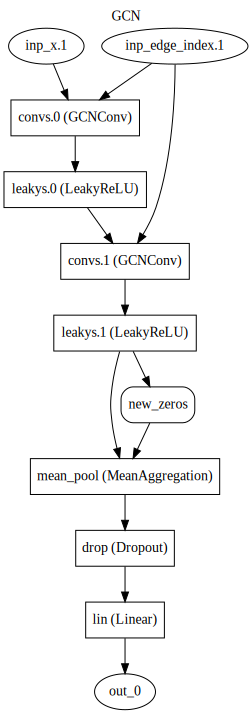

In [10]:
d.render('GCN')
d

In [ ]:
make_graph(mod, classes_to_visit=None, classes_found=None, dot=None, prefix="", input_preds=None, parent_dot=None)